In this notebook we will use NR waveforms for a single binary system
to fit a phenomenological model to the data that include uncertainty
due to numerical resolution.

EDIT: The SXS waveforms I have here do not show a large enough difference
between resolutions (potentially due to their adaptive resolution algorithm)
to easily see. I will compare an NR waveform with some waveform models instead

# imports

In [77]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})
default_cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(default_cycle_colors)

from cycler import cycler
import numpy as np

import glob
import os

import lal
import lalsimulation as lalsim

import utils

<Figure size 432x288 with 0 Axes>

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [78]:
import pycbc.pnutils

In [79]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy import optimize

In [80]:
import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

# helpers

In [81]:
def sech(x):
    return 1/np.cosh(x)

In [82]:
def make_nr_dict(root_dir):
    """
    makes a dictionary of paths to NR files
    with multiple resolutions
    """
    nr_ids = dict(q1="180", q2="169", q4="167", q5="107", q10="303")

    nrfiles = {}

    for key, val in nr_ids.items():
        ps = glob.glob(os.path.join(root_dir, "*" + val + "*.h5"))

        nrfiles.update({key: {}})
        for p in ps:
            k = p.split("/")[-1].split(".h5")[0].split("_")[-1]
            nrfiles[key].update({k: p})

    return nrfiles

In [83]:
def gen_model_waveform(approx, q, npts):
    lal_approx = lalsim.GetApproximantFromString(approx)
    return utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts)

In [84]:
def get_t_of_f(t, f, f0):
    """
    use this to find the time at which a frequency f0 occures
    """
    # only look at times before peak because NR data can result
    # non-monotonic function due to noise in the ringdown
    mask = t < 0
    iy = IUS(t[mask], f[mask]-f0)
    
    sol = optimize.root(iy, 0, method='hybr')
    return sol.x[0]

# config

In [85]:
# root_dir = "/Users/spx8sk/work/data"
# root_dir = "/Volumes/ancient/mirror/machines/CU_mbp/work/data"
root_dir = "/Users/sebastian.khan/personal/data"

npts = 1000

mtot=1

# mass-ratio key
q = 18
q_key = f'q{q}'

m1, m2 = phenom.m1_m2_M_q(mtot, q)
meco_frequency = phenom.HztoMf(pycbc.pnutils.meco_frequency(m1,m2, 0, 0), mtot)*2*np.pi
hybrid_meco_frequency = phenom.HztoMf(pycbc.pnutils.hybrid_meco_frequency(m1, m2, 0, 0), 1)*2*np.pi

print(f"{meco_frequency = }")
print(f"{hybrid_meco_frequency = }")

# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "IMRPhenomC", "IMRPhenomB"]
approxs = ["SEOBNRv4_opt", "IMRPhenomD", "IMRPhenomT", "TEOBResumS"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "IMRPhenomT", "TEOBResumS", "IMRPhenomC", "IMRPhenomB"]

to_model = 'amp'
# to_model = 'phase'
# to_model = 'freq'

# get data
nrfiles = dict(
    q1=os.path.join(root_dir, "SXS_BBH_0180_Res4.h5"),
    q2=os.path.join(root_dir, "SXS_BBH_0169_Res5.h5"),
    q4=os.path.join(root_dir, "SXS_BBH_0167_Res5.h5"),
    q5=os.path.join(root_dir, "SXS_BBH_0107_Res5.h5"),
    q10=os.path.join(root_dir, "SXS_BBH_0303_Res5.h5"),
    q18=os.path.join(root_dir, "q18a0a0c025_144-22-hybrid.h5"),
)

meco_frequency = 0.18330810672685316
hybrid_meco_frequency = 0.13935066770814478


In [86]:
# nrfiles = make_nr_dict(root_dir)
# nrfiles

# generate data

In [87]:
target_wf = utils.WaveformGeneration(nrfile=nrfiles[q_key], npts=npts)

In [88]:
target_wf

In [89]:
# estimate time of meco
t_meco = get_t_of_f(target_wf.times, target_wf.freq, -meco_frequency)
t_meco

-28.47185968534636

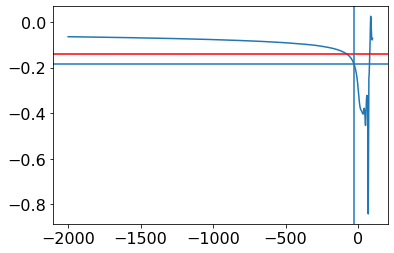

In [90]:
plt.plot(target_wf.times, target_wf.freq)
plt.axhline(-meco_frequency)
plt.axhline(-hybrid_meco_frequency, c='r')
plt.axvline(t_meco)

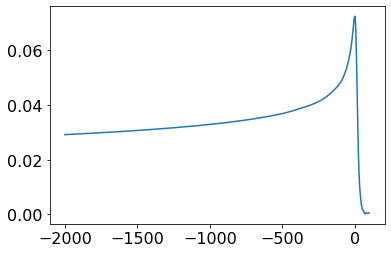

In [91]:
plt.plot(target_wf.times, target_wf.amp)

(-100.0, 205.0)

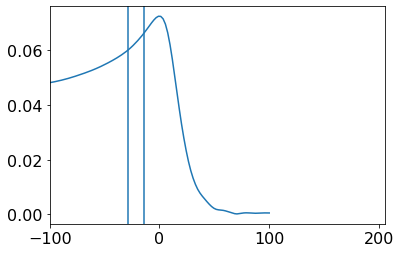

In [92]:
plt.plot(target_wf.times, target_wf.amp)
plt.axvline(t_meco)
plt.axvline(t_meco*0.5)
plt.xlim(-100)

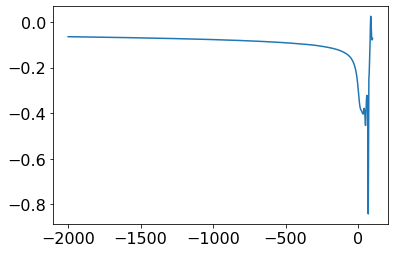

In [93]:
plt.plot(target_wf.times, target_wf.freq)

In [94]:
# generate other waveforms to compare with
other_wfs = [gen_model_waveform(approx, q, npts) for approx in approxs]

In [95]:
other_wfs

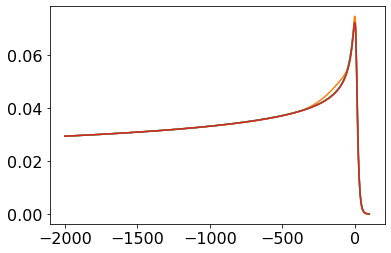

In [96]:
for wf in other_wfs:
    plt.plot(wf.times, wf.amp)

# define highest resolution and compute error

In [97]:
errors = np.array([target_wf.__getattribute__(to_model) - wf.__getattribute__(to_model) for wf in other_wfs])

In [98]:
# I don't think these two error estimates are correct
# error_conservative = errors.max(0) - errors.min(0)
# error_conservative = errors.max(0) + errors.min(0)


# I think this is the correct one.
error_conservative = np.max([np.abs(errors.max(0)), np.abs(errors.min(0))], 0)

In [99]:
error_conservative.shape

(1000,)

Text(0.5, 1.0, 'error functions')

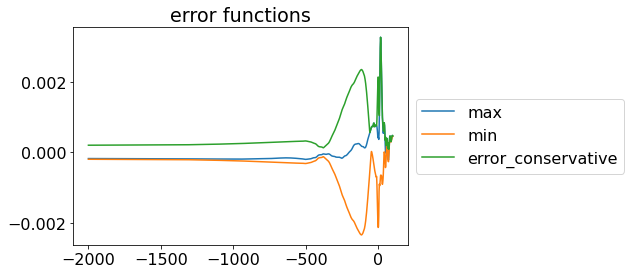

In [100]:
plt.plot(target_wf.times, errors.max(0), label='max')
plt.plot(target_wf.times, errors.min(0), label='min')
plt.plot(target_wf.times, error_conservative, label='error_conservative')
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("error functions")

Text(0.5, 1.0, 'error functions')

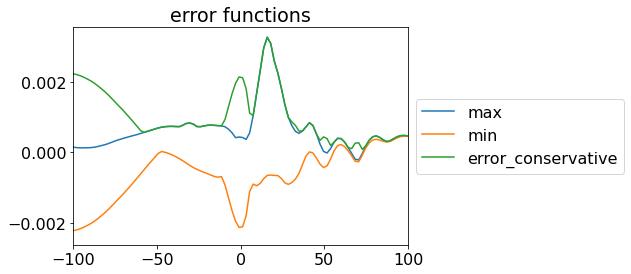

In [101]:
plt.plot(target_wf.times, errors.max(0), label='max')
plt.plot(target_wf.times, errors.min(0), label='min')
plt.plot(target_wf.times, error_conservative, label='error_conservative')
plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("error functions")

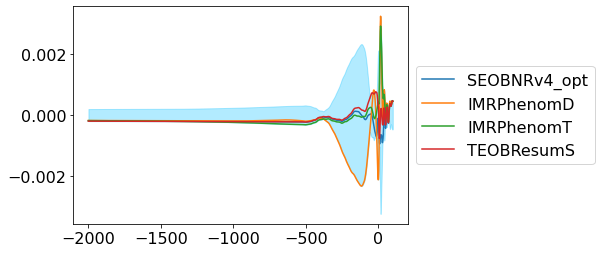

In [102]:
for i in range(len(errors)):
    plt.plot(target_wf.times, errors[i], label=lalsim.GetStringFromApproximant(other_wfs[i].approximant))
    
# plt.plot(target_wf.times, errors.min(0))
# plt.plot(target_wf.times, errors.max(0))
plt.fill_between(target_wf.times, y1=-error_conservative, y2=error_conservative, alpha=0.3, color='deepskyblue')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

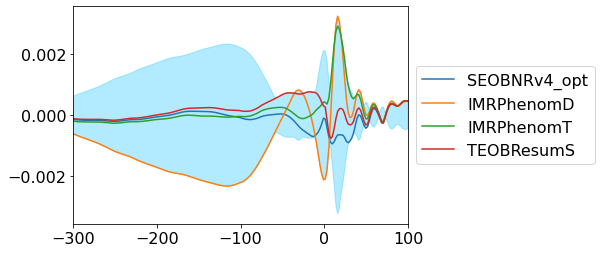

In [103]:
for i in range(len(errors)):
    plt.plot(target_wf.times, errors[i], label=lalsim.GetStringFromApproximant(other_wfs[i].approximant))
    
# plt.plot(target_wf.times, errors.min(0))
# plt.plot(target_wf.times, errors.max(0))
plt.fill_between(target_wf.times, y1=-error_conservative, y2=error_conservative, alpha=0.3, color='deepskyblue')
plt.xlim(-300, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

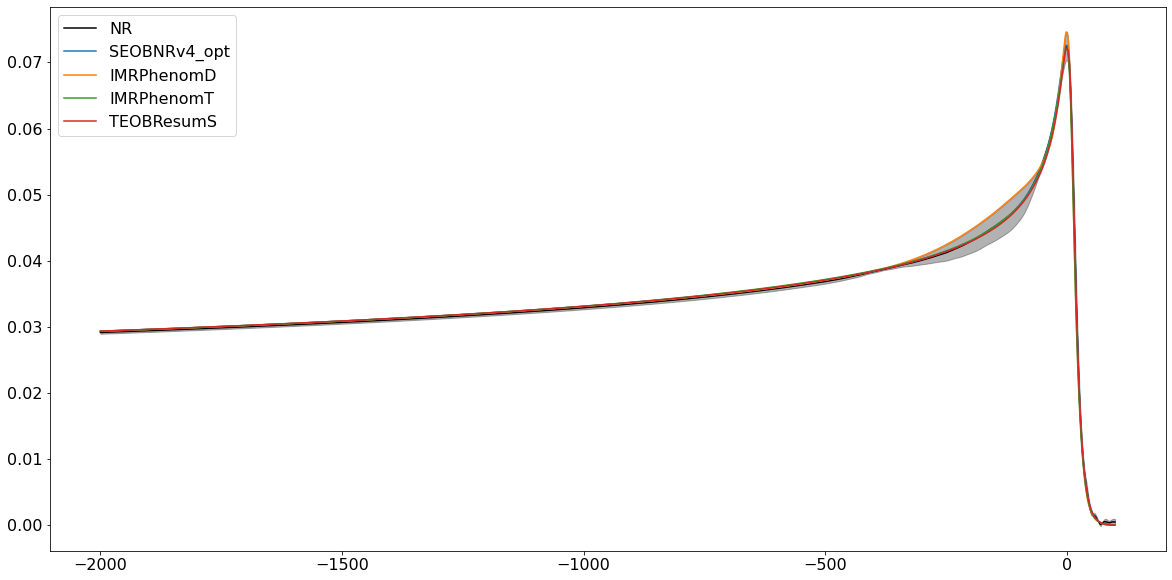

In [104]:
plt.figure(figsize=(20, 10))
y1=target_wf.__getattribute__(to_model) - error_conservative
y2=target_wf.__getattribute__(to_model) + error_conservative
plt.plot(target_wf.times, target_wf.__getattribute__(to_model), c='k', label="NR")
plt.fill_between(target_wf.times, y1=y1, y2=y2, color='k', alpha=0.3)

for wf in other_wfs:
    plt.plot(wf.times, wf.__getattribute__(to_model), label=lalsim.GetStringFromApproximant(wf.approximant))
    
# plt.yscale('log')
# plt.xlim(-100, 100)
# plt.ylim(-175, -100)
plt.legend()

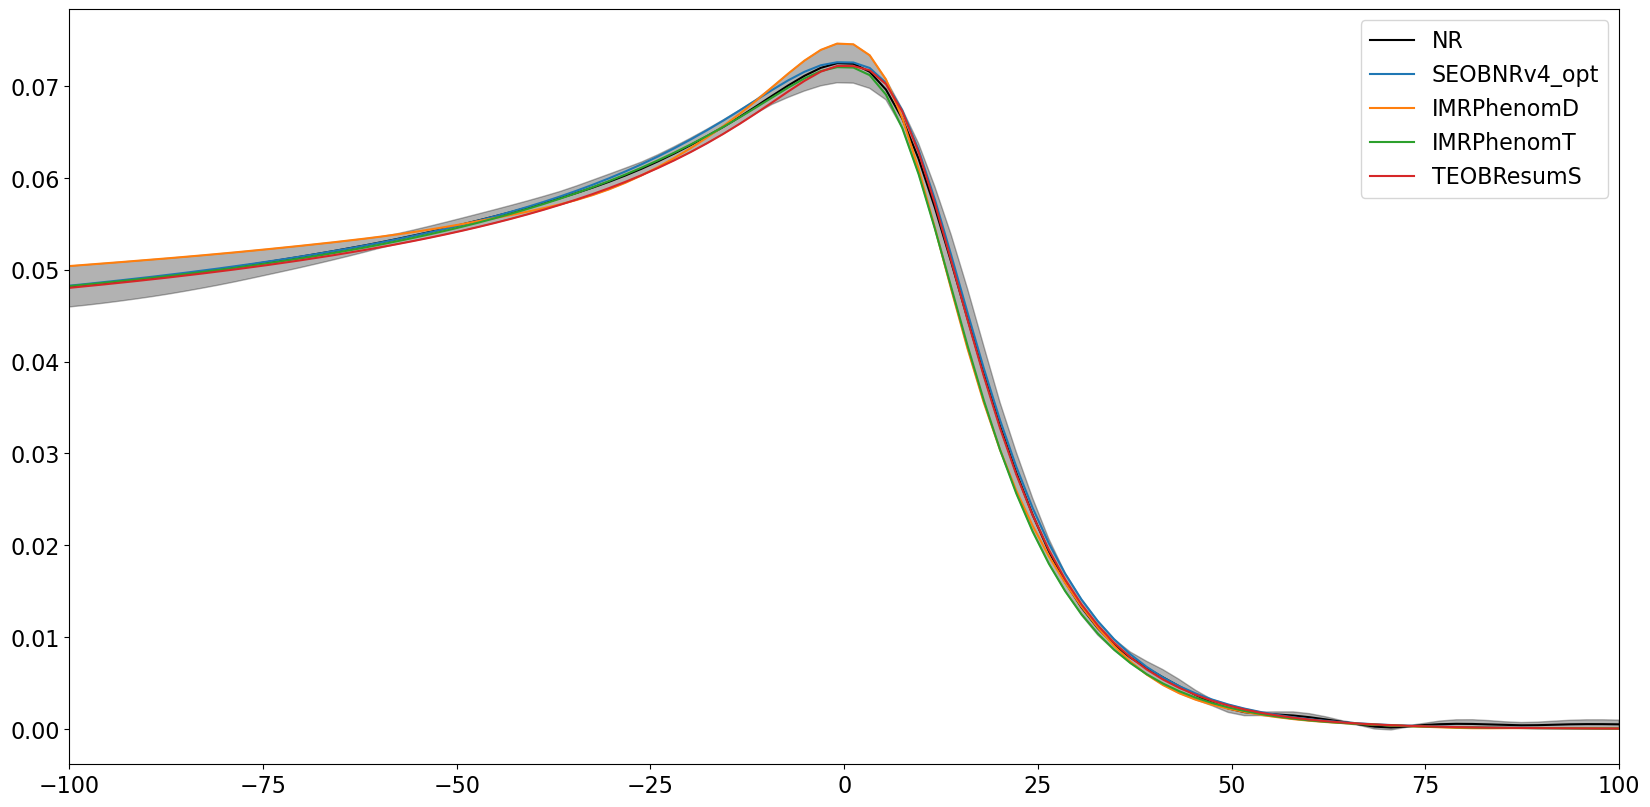

In [105]:
plt.figure(figsize=(20, 10), dpi=100)
y1=target_wf.__getattribute__(to_model) - error_conservative
y2=target_wf.__getattribute__(to_model) + error_conservative
plt.plot(target_wf.times, target_wf.__getattribute__(to_model), c='k', label="NR")
plt.fill_between(target_wf.times, y1=y1, y2=y2, color='k', alpha=0.3)

for wf in other_wfs:
    plt.plot(wf.times, wf.__getattribute__(to_model), label=lalsim.GetStringFromApproximant(wf.approximant))
    
# plt.yscale('log')
plt.xlim(-100, 100)
# plt.xlim(-10, 100)
# plt.ylim(-175, -100)
# plt.axvline(20)
plt.legend()

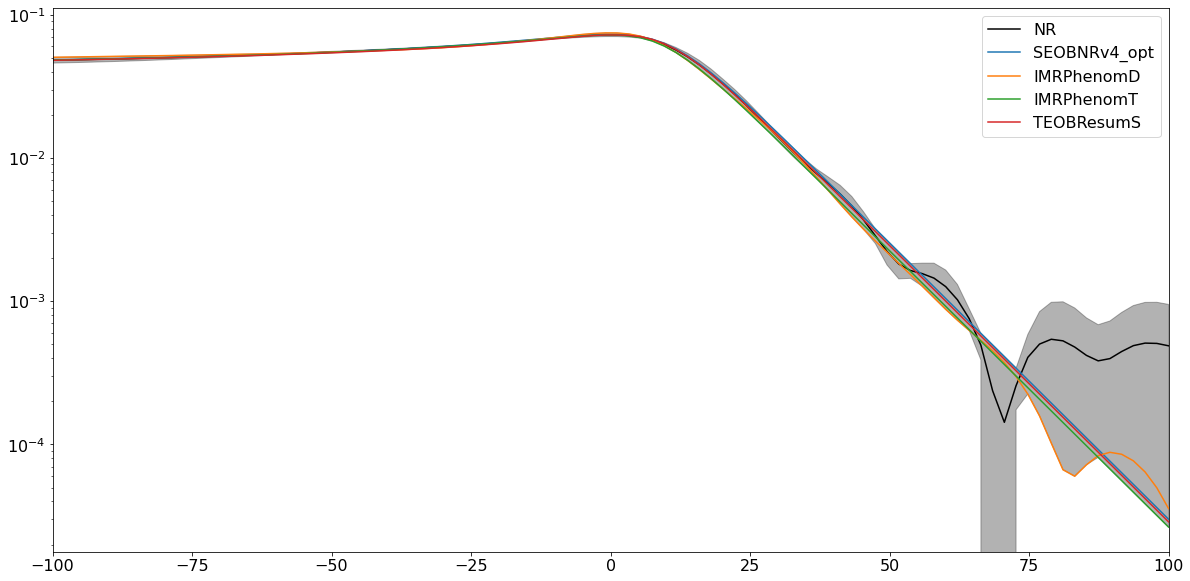

In [106]:
plt.figure(figsize=(20, 10))
y1=target_wf.__getattribute__(to_model) - error_conservative
y2=target_wf.__getattribute__(to_model) + error_conservative
plt.plot(target_wf.times, target_wf.__getattribute__(to_model), c='k', label="NR")
plt.fill_between(target_wf.times, y1=y1, y2=y2, color='k', alpha=0.3)

for wf in other_wfs:
    plt.plot(wf.times, wf.__getattribute__(to_model), label=lalsim.GetStringFromApproximant(wf.approximant))
    
plt.yscale('log')
plt.xlim(-100, 100)
# plt.ylim(-175, -100)
plt.legend()

# test fit

In [107]:
class Model_Amp_Int(object):
    """
    """
    def __init__(self, x, y, q):
        self.x = x
        self.y = y
        
        self.q = q
        self.eta = phenom.eta_from_q(self.q)
        
        self.fin_spin = phenom.remnant.FinalSpin0815(self.eta, 0, 0)
        self.fring = phenom.remnant.fring(self.eta, 0, 0, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(self.eta, 0, 0, self.fin_spin)
        
    def ansatz(self, params, t):
        
        # b0 = params['b0']
        # b1 = params['b1']
        # b2 = params['b2']
        # b3 = params['b3']
        
        a1 = params['a1']
        
        # print(type(params))
    
        # model = b0 + b1*t**2 + b2*np.power(sech(a1*t), 1./7.) + b3*sech(a1*t)
        # model = b0 + b2*np.arcsinh(a1*t)**1 + b3*np.arcsinh(a1*t)**2 + params['b4']*np.arcsinh(a1*t)**3 + params['b5']*np.arcsinh(a1*t)**4 + params['b6']*np.arcsinh(a1*t)**5 + b1*np.arcsinh(a1*t)**6
        
        # express model as dot-product of two vectors
        coeffs = []
        for p in list(params.keys()):
            if p.startswith('b'):
                coeffs.append(params[p])
        
        coeffs = np.array(coeffs)
        basis = np.array([np.power(np.arcsinh(a1*t), i) for i in range(len(coeffs))])
        model = np.dot(coeffs, basis)

        return model
    
    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data
        
    def fit(self, t1=-100, t2=0, num_b_coeffs=5):

        self.mask = (self.x > t1) & (self.x < t2)
        self.fit_times = self.x[self.mask]
        self.fit_data = self.y[self.mask]
        
        
        # we fit the square of the data for the amp model
        # self.fit_data = self.fit_data**2
        
        # create a set of Parameters
        params = Parameters()
        
        # params.add('b0', value=10., min=-5000, max=5000, vary=True)
        # params.add('b1', value=10., min=-5000, max=5000, vary=True)
        # params.add('b2', value=20., min=-5000, max=5000, vary=True)
        # params.add('b3', value=10., min=-5000, max=5000, vary=True)
        # params.add('b4', value=10., min=-5000, max=5000, vary=True)
        # params.add('b5', value=10., min=-5000, max=5000, vary=True)
        # params.add('b6', value=10., min=-5000, max=5000, vary=True)
        
        for i in range(num_b_coeffs):
            params.add(f'b{i}', value=10., min=-5000, max=5000, vary=True)
        
        params.add('a1', value=self.fdamp*2*np.pi, vary=False)
        
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params, self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')
        
        # axes[0].set_yscale('log')
        
        
        plt.show()
        plt.close()

In [108]:
# example_fit = Model_Amp_Int(target_wf.times, target_wf.amp, q)
example_fit = Model_Amp_Int(target_wf.times, target_wf.__getattribute__(to_model), q)
# example_fit = Model_Amp_Int(other_wfs[0].times, other_wfs[0].amp, q)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 123
    # data points      = 143
    # variables        = 5
    chi-square         = 9.0829e-07
    reduced chi-square = 6.5818e-09
    Akaike info crit   = -2689.06051
    Bayesian info crit = -2674.24629
[[Variables]]
    b0:  0.07260140 +/- 7.7157e-05 (0.11%) (init = 10)
    b1:  8.5533e-04 +/- 2.3429e-04 (27.39%) (init = 10)
    b2: -0.00664016 +/- 1.8880e-04 (2.84%) (init = 10)
    b3: -0.00187945 +/- 6.2570e-05 (3.33%) (init = 10)
    b4: -1.6950e-04 +/- 9.8621e-06 (5.82%) (init = 10)
    a1:  0.0888438 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b3, b4) = 0.994
    C(b2, b3) = 0.989
    C(b1, b2) = 0.974
    C(b2, b4) = 0.966
    C(b1, b3) = 0.931
    C(b1, b4) = 0.888
    C(b0, b1) = 0.878
    C(b0, b2) = 0.766
    C(b0, b3) = 0.688
    C(b0, b4) = 0.630


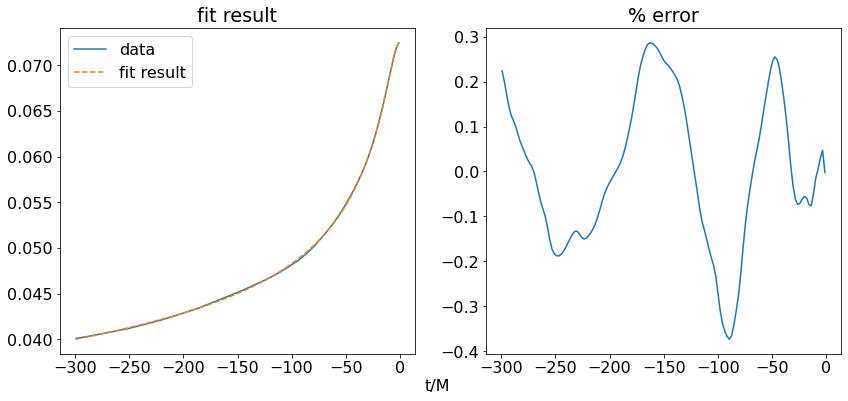

In [109]:
# example_fit.fit(-500, 0, 6)
example_fit.fit(-300, 0, 5)
example_fit.plot_result()

In [110]:
example_fit.result.params['a1'].value

0.08884379830973986

In [111]:
xx = np.linspace(-100, 100, 1000)

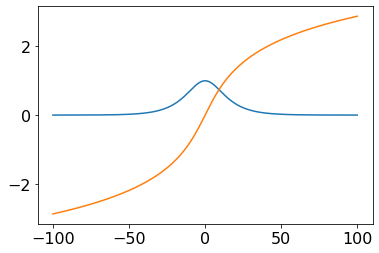

In [112]:
plt.plot(xx, sech(example_fit.result.params['a1'].value * xx))
plt.plot(xx, np.arcsinh(example_fit.result.params['a1'].value * xx))
# plt.plot(xx, sech(example_fit.result.params['a1'].value * xx)**(1/7))
# plt.plot(xx, sech(example_fit.result.params['a1'].value * xx)**(10/100))

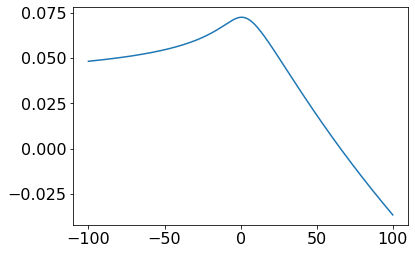

In [113]:
plt.plot(xx, example_fit.ansatz(example_fit.result.params, xx))

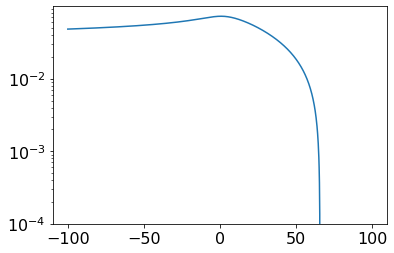

In [114]:
plt.plot(xx, example_fit.ansatz(example_fit.result.params, xx))
plt.yscale('log')

# collocation method fit

In [115]:
def d_arcsinh_dx(x, a, power=0):
    if power == 0:
        return 0*x
    else:
        return a / np.sqrt(np.power(a*x,2)+1) * (power * np.arcsinh(a*x)**(power-1))
    
    
    
def d2_arcsinh_d2x(x, a, power=0):
    # 2nd derivative of arcsinh(a*x)^power
    if power == 0:
        return 0*x
    else:
        
        a2 = a*a
        ax = a*x
        ax2 = ax*ax
        ax2_p_1 = ax2 + 1
        
        sqrt_ax2_p_1 = np.sqrt(ax2_p_1)
        ax2_p_1_pow_3_over_2 = np.power(ax2_p_1, 3./2.)
        
        if power == 1:
            num = -a2*ax
            den = ax2_p_1_pow_3_over_2
            return num / den
        elif power == 2:
            num = 2*a2*(sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = sqrt_ax2_p_1
            return num / den
        elif power == 3:
            num = 3*a2*np.arcsinh(ax) * (2*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 4:
            num = 4*a2*np.arcsinh(ax) * (3*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 5:
            num = 5*a2*np.arcsinh(ax) * (4*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 6:
            num = 6*a2*np.arcsinh(ax) * (5*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 7:
            num = 7*a2*np.arcsinh(ax) * (6*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 8:
            num = 8*a2*np.arcsinh(ax) * (7*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 9:
            num = 9*a2*np.arcsinh(ax) * (8*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 10:
            num = 10*a2*np.arcsinh(ax) * (9*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den

In [116]:
class Collocation_Model_Amp_Int(object):
    """
    """
    def __init__(self, x, y, q, n_coeffs):
        self.x = x
        self.y = y
        
        self.q = q
        self.eta = phenom.eta_from_q(self.q)
        
        self.fin_spin = phenom.remnant.FinalSpin0815(self.eta, 0, 0)
        self.fring = phenom.remnant.fring(self.eta, 0, 0, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(self.eta, 0, 0, self.fin_spin)
        
        self.a1 = self.fdamp * 2 * np.pi
        self.n_coeffs = n_coeffs
        
    def basis(self, t):
        a1 = self.a1
        
        basis = np.array([np.power(np.arcsinh(a1*t), i) for i in range(self.n_coeffs)])
        # basis = np.array([np.power((a1*t), i) for i in range(self.n_coeffs)])

        return basis

    def basis_1st_deriv(self, t):
        a1 = self.a1
        
        basis = np.array([d_arcsinh_dx(t, a1, power=i) for i in range(self.n_coeffs)])

        # basis = np.array([np.power((a1*t), i) for i in range(self.n_coeffs)])

        return basis
    
    def basis_2nd_deriv(self, t):
        a1 = self.a1
        
        basis = np.array([d2_arcsinh_d2x(t, a1, power=i) for i in range(self.n_coeffs)])
        # basis = np.array([np.power((a1*t), i) for i in range(self.n_coeffs)])
        
        return basis
    
    def create_information_matrix(self, val_c_points, deriv_c_points=None, deriv_2_c_points=None):
        """
        val_c_points: list of times to build equations constraining the value of the function
        deriv_c_points: list of times to build equations constraining the 1st derivative value of the function
        """
        
        if val_c_points is not None:
            A_val = self.basis(val_c_points)
        if deriv_c_points is not None:
            A_1st_deriv = self.basis_1st_deriv(deriv_c_points)
        if deriv_2_c_points is not None:
            A_2nd_deriv = self.basis_2nd_deriv(deriv_2_c_points)
        # output shape: (num equations, num coeffs)
        
        if val_c_points  is not None and deriv_c_points  is not None and deriv_2_c_points is not None:
            return np.column_stack((A_val, A_1st_deriv, A_2nd_deriv)).T
        if val_c_points  is not None and deriv_c_points  is not None:
            return np.column_stack((A_val, A_1st_deriv)).T
        if val_c_points is not None:
            return A_val.T
        # if deriv_c_points is not None:
        #     return A_1st_deriv.T
        # if deriv_2_c_points is not None:
        #     return A_2nd_deriv.T

In [225]:
# val_c_points = np.array([-100, -50, 0, 10, -20])
# deriv_c_points = np.array([-100, 0])

# val_c_points = np.array([-100, -50, 0, -20, -200])
# deriv_c_points = None

# val_c_points = np.array([-100, -50, -25, 0])
# deriv_c_points = np.array([-100, 0])
# deriv_2_c_points = np.array([-100, 0])

# val_c_points = np.array([-100, -25, 0])
# deriv_c_points = np.array([-100, 0])
# deriv_2_c_points = np.array([0])

# val_c_points = np.array([-200, -100, -50, -25, 0, 10])
# val_c_points = np.array([-200, -100, -50, -25, 0, 20])
# # deriv_c_points = np.array([-200, -100, 0, 20])
# deriv_c_points = np.array([-200, 0, 20])
# deriv_2_c_points = np.array([0])
# deriv_2_c_points=None

# val_c_points = np.array([-100, -50, -25, 0, 10, 20])
# val_c_points = np.array([-100, -50, -20, 0, 10, 20, 30])
# val_c_points = np.array([-100, -50, -20, 0, 10, 30])
# val_c_points = np.array([-100, -30, 0])
val_c_points = np.array([4*t_meco, t_meco, 0])
# # deriv_c_points = np.array([-200, -100, 0, 20])
# # deriv_c_points = np.array([-100, 0, 20])
deriv_c_points = np.array([4*t_meco, 0])
# deriv_2_c_points = np.array([0])
deriv_2_c_points=None


# potentially could use this to model peak-to-30M.
# I think this has one free parameter?
# just the value of the amplitude at t=30M
# t=0 will be fixed by merger 
# t=30M derivative is known if we assume we are in the ringdown regime
# val_c_points = np.array([0, 30])
# deriv_c_points = np.array([0, 30])
# deriv_2_c_points = np.array([0])

In [226]:
# n_coeffs = np.concatenate((val_c_points, deriv_c_points, deriv_2_c_points)).shape[0]
n_coeffs = np.concatenate((val_c_points, deriv_c_points)).shape[0]

In [227]:
n_coeffs

5

In [228]:
c_model = Collocation_Model_Amp_Int(target_wf.times, target_wf.amp, q, n_coeffs)

In [229]:
information_matrix = c_model.create_information_matrix(val_c_points, deriv_c_points, deriv_2_c_points)

In [230]:
information_matrix.shape

(5, 5)

In [231]:
# collocation_points = np.array([-100, -50, -20, -10, 0])
# collocation_points = np.array([-100, 0])

In [232]:
# c_model.basis(collocation_points).shape

In [233]:
# c_model.basis(collocation_points)

In [234]:
iy = IUS(target_wf.times, target_wf.__getattribute__(to_model))

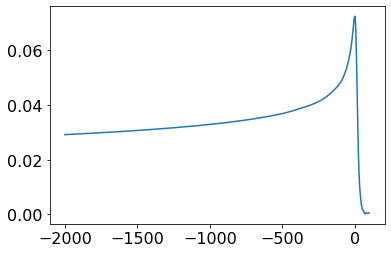

In [235]:
plt.plot(target_wf.times, iy(target_wf.times))

In [236]:
# iy(collocation_points)

In [237]:
iy(val_c_points)

array([0.04715246, 0.0601781 , 0.07254804])

In [238]:
iy.derivative()(deriv_c_points)

array([6.75988703e-05, 1.92631885e-08])

In [239]:
# c_model.basis(collocation_points).shape

In [240]:
iy.derivative()(deriv_c_points)

array([6.75988703e-05, 1.92631885e-08])

In [241]:
ys = np.concatenate((iy(val_c_points), iy.derivative()(deriv_c_points)))
# play with random noise to simulate modelling error
# ys += np.random.normal(0, 0.001, size=c_model.n_coeffs)

In [242]:
ys

array([4.71524640e-02, 6.01780987e-02, 7.25480392e-02, 6.75988703e-05,
       1.92631885e-08])

In [243]:
# ys[:-1] += np.random.normal(0, 0.001, size=c_model.n_coeffs-1)

In [244]:
ys

array([4.71524640e-02, 6.01780987e-02, 7.25480392e-02, 6.75988703e-05,
       1.92631885e-08])

(0.028995908490818456, 0.07466446436385753)

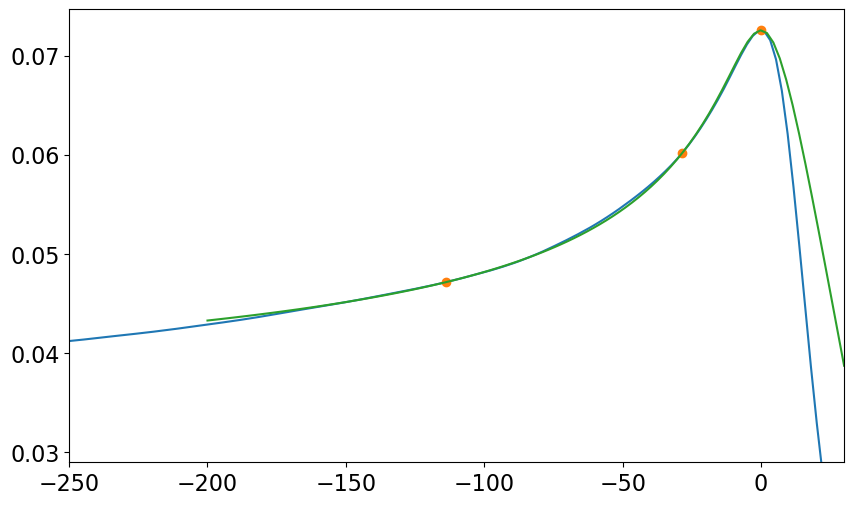

In [245]:
ymax = target_wf.__getattribute__(to_model).max()
ylim = [ymax*0.4, ymax*1.03]


ys = np.concatenate((iy(val_c_points), iy.derivative()(deriv_c_points)))
# ys = np.concatenate((iy(val_c_points), iy.derivative()(deriv_c_points), iy.derivative(2)(deriv_2_c_points)))

# ys = iy(val_c_points)
# play with random noise to simulate modelling error
# ys += np.random.normal(0, 0.0001, size=c_model.n_coeffs)


# ys

coeffs = np.linalg.solve(information_matrix, ys)
# coeffs

test_times = np.linspace(-200, 30, 100)

plt.figure(figsize=(10,6), dpi=100)
plt.plot(target_wf.times, target_wf.__getattribute__(to_model))
plt.plot(val_c_points, np.dot(coeffs, c_model.basis(val_c_points)), 'o')
plt.plot(test_times, np.dot(coeffs, c_model.basis(test_times)))

plt.xlim(-250, 30)
plt.ylim(*ylim)

(0.028995908490818456, 0.07466446436385753)

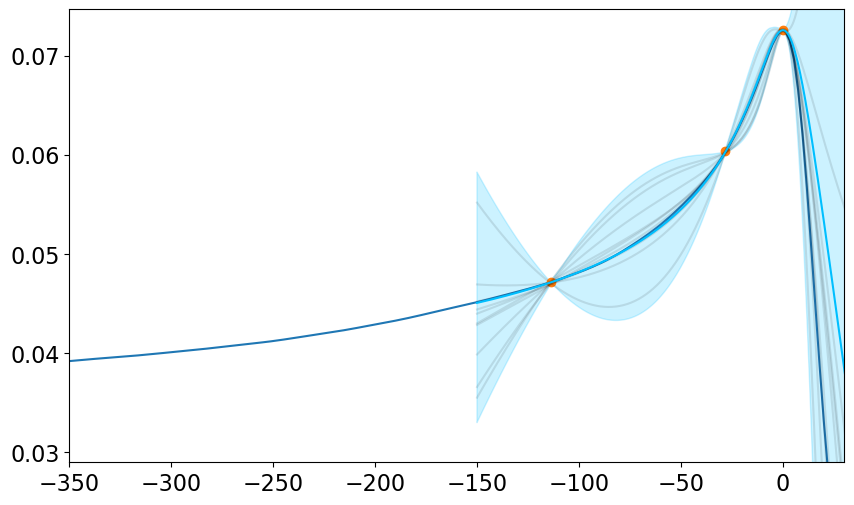

In [246]:
ymax = target_wf.__getattribute__(to_model).max()
ylim = [ymax*0.4, ymax*1.03]

test_times = np.linspace(-150, 35, 300)
n_tries = 100

yhats=[]
for n in range(n_tries):
    ys = np.concatenate((iy(val_c_points), iy.derivative()(deriv_c_points)))
    # ys = np.concatenate((iy(val_c_points), iy.derivative()(deriv_c_points), iy.derivative(2)(deriv_2_c_points)))
    # ys = iy(val_c_points)
    
    
    # play with random noise to simulate modelling error
    
    # assuming collocation points are independent
    ys += np.random.normal(0, 0.0001, size=c_model.n_coeffs)
    # noise = np.random.normal(0, 0.001, size=4)
    # ys[:4] += noise
    
    # correlated noise between collocation points
    # noise = np.random.normal(0, 0.001)
    # ys[0] += noise
    # ys[1] += noise
    # ys[2] += noise
    # ys[3] += noise
    # ys[4] += noise
    # ys[5] += noise
    
    coeffs = np.linalg.solve(information_matrix, ys)
    yhats.append(np.dot(coeffs, c_model.basis(test_times)))
yhats = np.array(yhats)


plt.figure(figsize=(10,6), dpi=100)
plt.plot(target_wf.times, target_wf.__getattribute__(to_model))
plt.plot(val_c_points, np.dot(coeffs, c_model.basis(val_c_points)), 'o')
for yhat in yhats[:10]:
    plt.plot(test_times, yhat, c='k', alpha=0.1)
    
plt.plot(test_times, yhats.mean(0), color='deepskyblue')
plt.fill_between(test_times, y1=yhats.min(0), y2=yhats.max(0), alpha=0.2, color='deepskyblue')
    
plt.xlim(-350, 30)
plt.ylim(*ylim)
# plt.xlim(-150, 30)
# plt.ylim(-0.6, -0.1)

# ringdown

(0.0, 40.0)

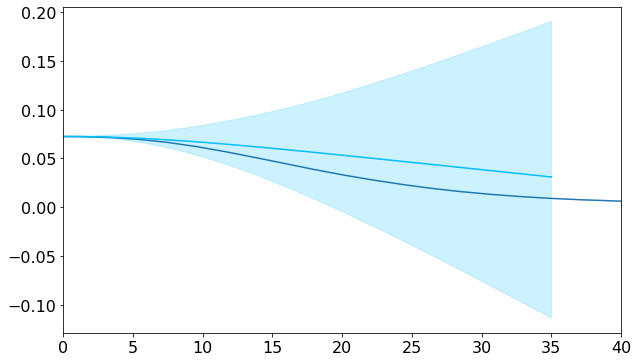

In [247]:
plt.figure(figsize=(10, 6))
plt.plot(target_wf.times, target_wf.__getattribute__(to_model))
plt.plot(test_times, yhats.mean(0), color='deepskyblue')
plt.fill_between(test_times, y1=yhats.min(0), y2=yhats.max(0), alpha=0.2, color='deepskyblue')
plt.xlim(0, 40)

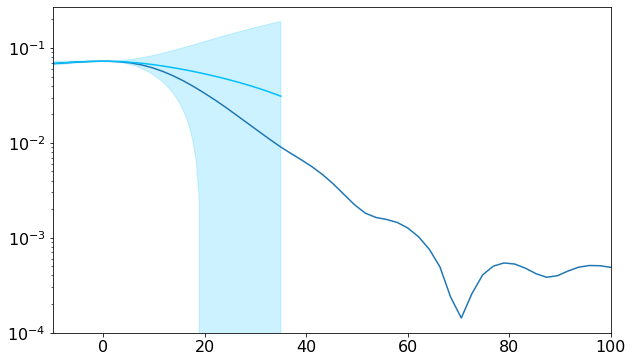

In [248]:
plt.figure(figsize=(10, 6))
plt.plot(target_wf.times, target_wf.__getattribute__(to_model))
plt.plot(test_times, yhats.mean(0), color='deepskyblue')
plt.fill_between(test_times, y1=yhats.min(0), y2=yhats.max(0), alpha=0.2, color='deepskyblue')
plt.xlim(-10, 100)
# plt.ylim(1e-2, 1)
plt.yscale('log')

In [249]:
c_model.fdamp

0.014139929664054475

In [250]:
def rd_ansatz(t, a, b):
    return a * np.exp(-t*b)

In [251]:
def rd_ansatz_log(t, a, b):
    return np.log(a) - t*b

In [252]:
t_rd = np.linspace(10, 60, 100)

(0.0, 100.0)

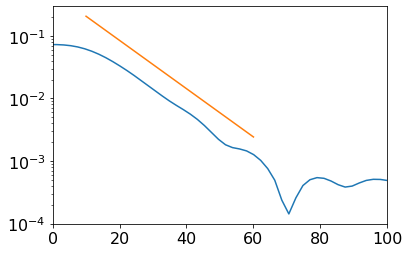

In [253]:
plt.plot(target_wf.times, target_wf.__getattribute__(to_model))
plt.plot(t_rd, rd_ansatz(t_rd, 0.5, c_model.fdamp*2*np.pi))
plt.yscale('log')
plt.xlim(0, 100)

In [254]:
iy(20)

array(0.03327627)

In [255]:
np.log(iy(20))

-3.4029108244167627

In [256]:
# y1 = nr
# y2 = rdmodel

# constraints

# y1(t0) = y2(t0)

# log(y1(t0)) = log(y2(t0))
# :> log(a) = log(y1(t0)) + b*t0

In [257]:
t0 = 30
b = c_model.fdamp*2*np.pi
log_a = np.log(iy(t0)) + b * t0
log_a

-1.603731637088012

(0.0, 100.0)

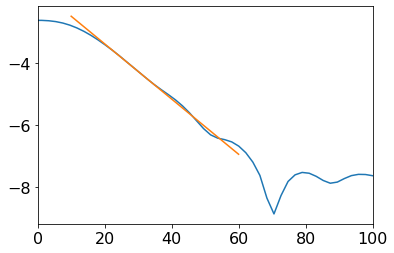

In [258]:
plt.plot(target_wf.times, np.log(target_wf.__getattribute__(to_model)))
# plt.plot(t_rd, np.log(rd_ansatz(t_rd, 0.5, c_model.fdamp*2*np.pi)))
plt.plot(t_rd, rd_ansatz_log(t_rd, np.exp(log_a), b))
# plt.yscale('log')
plt.xlim(0, 100)

(0.001, 0.3)

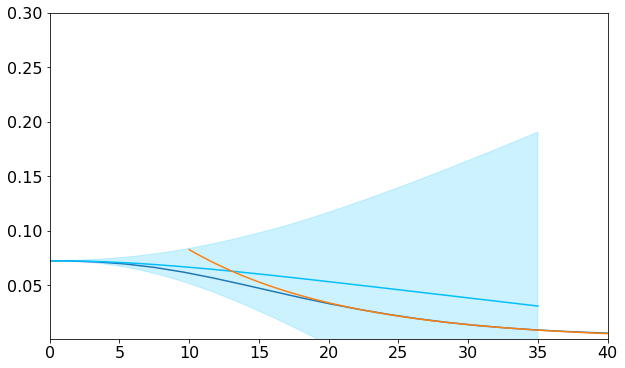

In [259]:
plt.figure(figsize=(10, 6))
plt.plot(target_wf.times, target_wf.__getattribute__(to_model))
plt.plot(test_times, yhats.mean(0), color='deepskyblue')
plt.fill_between(test_times, y1=yhats.min(0), y2=yhats.max(0), alpha=0.2, color='deepskyblue')
plt.plot(t_rd, np.exp(rd_ansatz_log(t_rd, np.exp(log_a), b)))

plt.xlim(0, 40)
plt.ylim(1e-3, 0.3)
# plt.yscale('log')

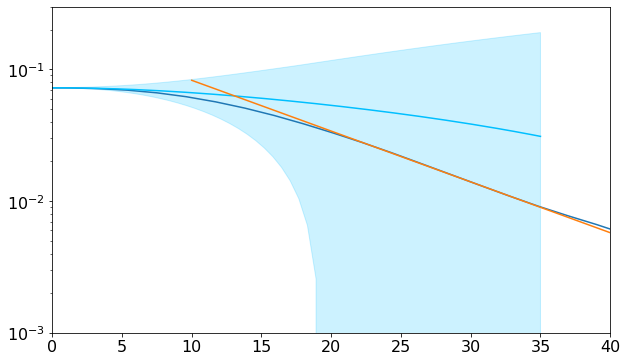

In [260]:
plt.figure(figsize=(10, 6))
plt.plot(target_wf.times, target_wf.__getattribute__(to_model))
plt.plot(test_times, yhats.mean(0), color='deepskyblue')
plt.fill_between(test_times, y1=yhats.min(0), y2=yhats.max(0), alpha=0.2, color='deepskyblue')
plt.plot(t_rd, np.exp(rd_ansatz_log(t_rd, np.exp(log_a), b)))

plt.xlim(0, 40)
plt.ylim(1e-3, 0.3)
plt.yscale('log')

i think that we can use f_damp and the ring down exponential model to fix the merge ansatz
1st derivative at t=20M?

and maybe 2nd derivative too?

all we would need is the value of the amplitude at t=20M then